## Previsao de Embarque - Sem Serie Temporal

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from IPython.display import display
#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')


In [2]:
day_of_week_translator = {
    0: "Domingo",
    1: "Segunda",
    2: "Terca",
    3: "Quarta",
    4: "Quinta",
    5: "Sexta",
    6: "Sabado"
}

feriados = [
            ['Ano Novo', 1, 1],
            ['Carnaval', 24, 2],
            ['Carnaval', 25, 2],
            ['Carnaval', 26, 2],
            ['Dia de São José', 19, 3],
            ['Data Magna', 25, 3],
            ['Sexta-Feira Santa', 10, 4],
            ['Aniversário de Fortaleza', 13, 4],
            ['Tiradentes', 21, 4],
            ['Dia do Trabalho', 1, 5],
            ['Corpus Christi', 28, 5],
            ['N. Senhora da Assunção', 27, 5],
            ['Independência do Brasil', 7, 9],
            ['N. Senhora de Aparecida', 12, 10],
            ['Dia de Finados', 2, 11],
            ['Proclamação da Republica', 15, 11],
            ['Natal', 25, 12],
]

vesperas = [
            ['Ano Novo', 31, 12],
            ['Carnaval', 23, 2],
            ['Dia de São José', 18, 3],
            ['Data Magna', 24, 3],
            ['Sexta-Feira Santa', 9, 4],
            ['Aniversário de Fortaleza', 12, 4],
            ['Tiradentes', 20, 4],
            ['Dia do Trabalho', 30, 4],
            ['N. Senhora da Assunção', 26, 5],
            ['Independência do Brasil', 6, 9],
            ['N. Senhora de Aparecida', 11, 10],
            ['Dia de Finados', 1, 11],
            ['Proclamação da Republica', 14, 11],
            ['Natal', 24, 12],
]

In [3]:
# Reading Data file (geolocalized)
data = pd.read_csv('./df_input.csv', sep=';', delimiter=';')

busline_filter = 41
data_model = data.loc[data['linha'] == busline_filter]
encoded_model_data = data_model.copy()

one_hot_encoder = OneHotEncoder(sparse=False)

encoded_model_data[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
encoded_model_data['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(encoded_model_data.d_mes, encoded_model_data.mes))]
encoded_model_data['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(encoded_model_data.d_mes, encoded_model_data.mes))]

display(encoded_model_data)

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
2418,41,2020-03-01 04:00:00,25,6,8.878852e-01,0.460065,4,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2419,41,2020-03-01 05:00:00,168,6,9.790841e-01,0.203456,5,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2420,41,2020-03-01 06:00:00,310,6,9.976688e-01,-0.068242,6,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2421,41,2020-03-01 07:00:00,339,6,9.422609e-01,-0.334880,7,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2422,41,2020-03-01 08:00:00,286,6,8.169699e-01,-0.576680,8,1,61,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418148,41,2020-12-31 20:00:00,138,3,-7.308360e-01,0.682553,20,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418149,41,2020-12-31 21:00:00,83,3,-5.195840e-01,0.854419,21,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418150,41,2020-12-31 22:00:00,54,3,-2.697968e-01,0.962917,22,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418151,41,2020-12-31 23:00:00,30,3,-2.449294e-16,1.000000,23,31,366,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [4]:
X = encoded_model_data.filter(['semana_do_mes', 'd_ano', 'hour_sin', 'hour_cos', 'd_mes', 'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 'feriado', 'vespera_feriado'], axis=1)
y = encoded_model_data.validations_per_hour
display(X)
display(y)

,semana_do_mes,d_ano,hour_sin,hour_cos,d_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
2418,0,61,8.878852e-01,0.460065,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2419,0,61,9.790841e-01,0.203456,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2420,0,61,9.976688e-01,-0.068242,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2421,0,61,9.422609e-01,-0.334880,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2422,0,61,8.169699e-01,-0.576680,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418148,4,366,-7.308360e-01,0.682553,31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418149,4,366,-5.195840e-01,0.854419,31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418150,4,366,-2.697968e-01,0.962917,31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1418151,4,366,-2.449294e-16,1.000000,31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


2418        25
2419       168
2420       310
2421       339
2422       286
          ... 
1418148    138
1418149     83
1418150     54
1418151     30
1418152      2
Name: validations_per_hour, Length: 6172, dtype: int64

In [5]:
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor(n_jobs=6)

def singlebusline_model(model, X, y):
    singlebusline_model = model
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
    singlebusline_model.fit(X_train, Y_train)
    performance_scoring = get_performance(model, X_test, Y_test)
    return singlebusline_model, performance_scoring

In [6]:
def get_performance(model, X_test, Y_test):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mean = mean_absolute_error(Y_test, y_test_predict)
    mape = mean_absolute_percentage_error(Y_test, y_test_predict)
    performance_scoring = [
        ("R2", r2),
        ("RMSE", rmse),
        ("MAE", mean),
        ("MAPE", mape)
    ]
    performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

In [7]:
print("###  1 Modelo Por Linha (dado completo de treino)")

model_per_line_lr, model_per_line_lr_performance = singlebusline_model(LinearRegressionModel, X, y)
model_per_line_rf, model_per_line_rf_performance = singlebusline_model(RandomForestModel, X, y)

print('Regressao Linear: \n', model_per_line_lr_performance)
print("\n----------------------------------------------------\n")
print('Random Forest: \n', model_per_line_rf_performance)

print("\nUtilizando sample aleatorio de dado para teste de previsao: ")

sample = X.sample(n=1)
predict_res = model_per_line_lr.predict(sample)
display(data_model.loc[sample.index[0]:sample.index[0]])
print("Regressao Linear -> resultado do predict de test: ", predict_res)

predict_res2 = model_per_line_rf.predict(sample)
print("Random Forest -> resultado do predict de test: ", predict_res2)

###  1 Modelo Por Linha (dado completo de treino)
Regressao Linear: 
   Metrica       Score
0      R2    0.372353
1    RMSE  215.750931
2     MAE  161.604793
3    MAPE    2.012027

----------------------------------------------------

Random Forest: 
   Metrica      Score
0      R2   0.976933
1    RMSE  41.360936
2     MAE  29.684160
3    MAPE   0.297166

Utilizando sample aleatorio de dado para teste de previsao: 


,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes
269407,41,2020-04-25 17:00:00,204,5,-0.997669,-0.068242,17,25,116,4,3


Regressao Linear -> resultado do predict de test:  [250.68997977]
Random Forest -> resultado do predict de test:  [207.26]


In [12]:
sample

,semana_do_mes,d_ano,hour_sin,hour_cos,d_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
269407,3,116,-0.997669,-0.068242,25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0


In [22]:
d_prev = []
for ds in range(7):
    d_mes = 5
    semana_do_mes = 3
    mes = 6
    d_ano = 120
    for h in range(24):
        h_sin= np.sin(2 * np.pi * h/23.0)
        h_cos = np.cos(2 * np.pi * h/23.0)
        d_prev.append(model_per_line_rf.predict([[semana_do_mes, d_ano, h_sin, h_cos, d_mes, 0, 0, 0,1,0,0,0,0,0]]))
    d_mes += 1
    d_ano += 1
    if d_mes >= 5+7:
        semana_do_mes +=1

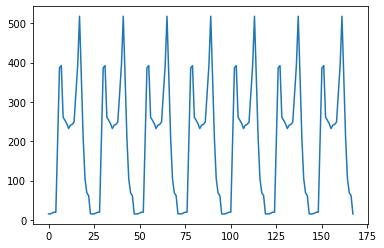

In [23]:
plt.plot(d_prev)